In [57]:
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,roc_curve,auc,precision_score,f1_score,accuracy_score,recall_score
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.manifold import TSNE

In [3]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [6]:
# Time based splittin
final = final.sort_values(by=['Time'],ascending=False)
finalDataPoints = final.head(20000)
x = finalDataPoints['CleanedText']
y = finalDataPoints['Score']
x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size=0.2,shuffle=False)
x_train,x_cv,y_train,y_cv = train_test_split(x_tr,y_tr,test_size = 0.2,shuffle=False)

In [7]:
#Bow->unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_train)
x_test_uni = bow.transform(x_test)
x_tr_uni = StandardScaler(with_mean=False).fit_transform(x_tr_uni)
x_test_uni = StandardScaler(with_mean=False).fit_transform(x_test_uni)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

Best Hyperparameter:  {'C': 0.01}
0.8752191545241221


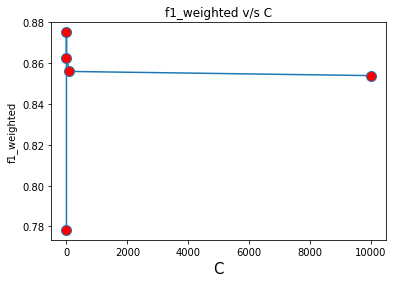

In [26]:
# Finding the optimal C using GridSearchCV
LR = LogisticRegression(penalty='l2')
C_value = [{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
gsv = GridSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_uni,y_train)
print("Best Hyperparameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C = gsv.best_score_
x=[]
y=[]
for i in range(0,len(C_value[0]['C'])): 
    x.append(gsv.cv_results_['params'][i]['C'])
    y.append(gsv.cv_results_["mean_test_score"][i])
plt.xlabel("C",fontsize=15)
plt.ylabel('f1_weighted')
plt.title("f1_weighted v/s C")
plt.plot(x,y,marker='o',markerfacecolor='red',markersize=10)
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy on test set: 86.025%
Precision on test set: 0.761
Recall on test set: 0.732
F1-Score on test set: 0.745


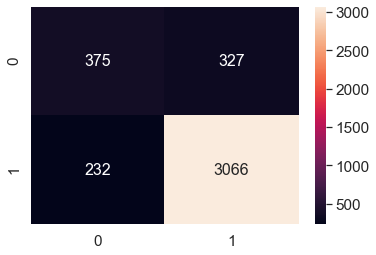

In [27]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_uni,y_train)
y_pred =LR.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [39]:
#finding the optimal C using randomSearchCV
LR = LogisticRegression(penalty = 'l2')
C_value = [{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_uni,y_train)
print("Best Hyperparameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C = gsv.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   13.9s finished


Best Hyperparameter:  {'C': 0.01}
0.8752191545241221


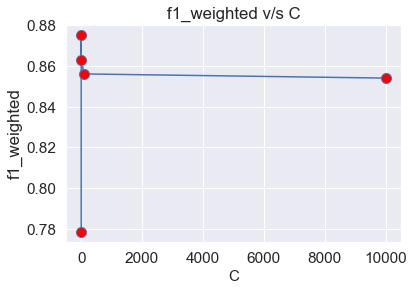

In [40]:
x=[]
y=[]
for i in range(0,len(C_value[0]['C'])): 
    x.append(gsv.cv_results_['params'][i]['C'])
    y.append(gsv.cv_results_["mean_test_score"][i])
plt.xlabel("C",fontsize=15)
plt.ylabel('f1_weighted')
plt.title("f1_weighted v/s C")
plt.plot(x,y,marker='o',markerfacecolor='red',markersize=10)
plt.show()

Accuracy on test set: 86.025%
Precision on test set: 0.761
Recall on test set: 0.732
F1-Score on test set: 0.745


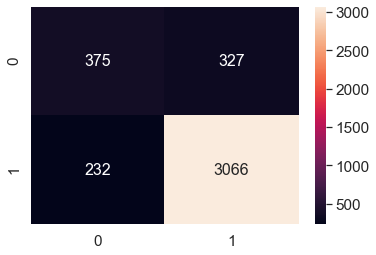

In [42]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_uni,y_train)
y_pred =LR.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [43]:
#TOP FEATURES
## Adding small noise in train data
epsilon = np.random.normal(loc=0.0,scale=0.00000001,size=x_tr_uni.shape)
x_tr_uni_epsilon = x_tr_uni+epsilon

In [44]:
#find with weight vector using train without noise
LR = LogisticRegression(penalty='l2',C=0.01)
LR.fit(x_tr_uni,y_train)
w_1 = LR.coef_

In [49]:
#Find with weight vector using train with noise
LR = LogisticRegression(penalty='l2',C=0.01)
LR.fit(x_tr_uni_epsilon,y_train)
w_2 = LR.coef_

In [50]:
w = (w_2-w_1)
w = w/w_1

In [51]:
w = np.nan_to_num(w)

In [52]:
w=w*100
w = w[np.where(w < 30)]

In [53]:
#dividing W list into p_pos(+ve feature) and n_neg(-ve feature)
w_pos_uni = w[np.where(w > 0)]
w_neg_uni = w[np.where(w < 0)]


In [54]:
features = (-w_neg_uni).argsort()
print(np.take(bow.get_feature_names(),features[:10]))

['burner' 'frederickand' 'giftcard' 'drunken' 'hor' 'meatfish' 'gruyer'
 'colleagu' 'capelin' 'gourmet']


In [55]:
features = (-w_pos_uni).argsort()
print(np.take(bow.get_feature_names(),features[:10]))

['flimsi' 'entireti' 'aspic' 'crip' 'brine' 'beg' 'againwil'
 'huskyshepherd' 'catfish' 'carman']


# L1-Regulerization using TFIDF-W2V

In [56]:
i = 0
list_of_sent = []
for sent in x_train:
    list_of_sent.append(sent.split())

i = 0
list_of_sent_test = []
for sent in x_test:
    list_of_sent_test.append(sent.split())    

In [58]:
w2v_model = Word2Vec(list_of_sent,min_count=5,size=50)

In [59]:
w2v_words = list(w2v_model.wv.vocab)
print('number of words that occured minimum 5 times',len(w2v_words))
print('sample words',w2v_words[0:50])

number of words that occured minimum 5 times 4594
sample words ['big', 'lover', 'fig', 'jam', 'uniqu', 'flavor', 'kind', 'mix', 'light', 'dark', 'mission', 'must', 'tri', 'hard', 'ever', 'write', 'review', 'rice', 'good', 'live', 'hawaii', 'never', 'seen', 'caribbean', 'sale', 'store', 'came', 'across', 'search', 'amazon', 'glad', 'gave', 'think', 'disappoint', 'ad', 'chop', 'chicken', 'suggest', 'also', 'small', 'onion', 'anoth', 'great', 'way', 'make', 'even', 'better', 'fresh', 'mango', 'simmer']


In [61]:
#TF-IDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_train)
dictionary = dict(zip(tf_idf_vect.get_feature_names(),list(tf_idf_vect.idf_)))

In [63]:
#TF-idf weighted Word2Vec
from tqdm import tqdm
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row = 0
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    weight_sum = 0
    
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /=weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row+=1

100%|███████████████████████████████████████████████████████████████████████████| 12800/12800 [00:23<00:00, 541.19it/s]


In [64]:
#TF-idf weighted Word2Vec
from tqdm import tqdm
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []
row = 0
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(50)
    weight_sum = 0
    
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /=weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row+=1

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 547.78it/s]


In [65]:
x_test_tdfw2v = tfidf_sent_vectors_test
x_tr_tdfw2v = tfidf_sent_vectors

x_test_tdfw2v = StandardScaler(with_mean=False).fit_transform(x_test_tdfw2v)
x_tr_tdfw2v = StandardScaler(with_mean=False).fit_transform(x_tr_tdfw2v)


In [68]:
LR = LogisticRegression(penalty = 'l2')
C_value = [{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
gsv = RandomizedSearchCV(LR,C_value,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_tdfw2v,y_train)
print("Best Hyperparameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_C = gsv.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    8.6s finished


Best Hyperparameter:  {'C': 100}
0.8373826064919555


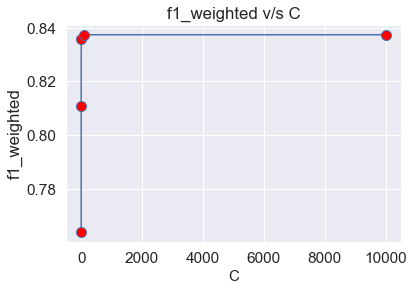

In [69]:
x=[]
y=[]
for i in range(0,len(C_value[0]['C'])): 
    x.append(gsv.cv_results_['params'][i]['C'])
    y.append(gsv.cv_results_["mean_test_score"][i])
plt.xlabel("C",fontsize=15)
plt.ylabel('f1_weighted')
plt.title("f1_weighted v/s C")
plt.plot(x,y,marker='o',markerfacecolor='red',markersize=10)
plt.show()

Accuracy on test set: 84.575%
Precision on test set: 0.754
Recall on test set: 0.618
F1-Score on test set: 0.645


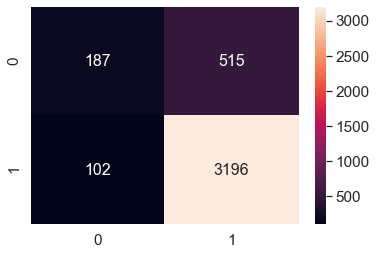

In [71]:
LR= LogisticRegression(penalty='l2',C=optimal_C)
LR.fit(x_tr_tdfw2v,y_train)
y_pred =LR.predict(x_test_tdfw2v)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')